In [1]:
from google.colab import files
files.upload()  # upload kaggle.json here


Saving kaggle (2).json to kaggle (2).json


{'kaggle (2).json': b'{"username":"mfurkanyumsak","key":"52931142e2c26962b8e293cfdc5f00f4"}'}

In [4]:
# Setup kaggle credentials
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Install kaggle API client
!pip install -q kaggle


In [5]:
# We only download the two files we need (not the full set!)

!kaggle competitions download -c amex-default-prediction -f train_data.csv


 99% 6.60G/6.67G [00:21<00:00, 140MB/s] 
100% 6.67G/6.67G [00:21<00:00, 334MB/s]


In [6]:
!kaggle competitions download -c amex-default-prediction -f train_labels.csv

  0% 0.00/16.2M [00:00<?, ?B/s]
100% 16.2M/16.2M [00:00<00:00, 1.13GB/s]


In [9]:
# Unzip

!unzip train_labels.csv
!unzip train_data.csv


Archive:  train_labels.csv
  End-of-central-directory signature not found.  Either this file is not
  a zipfile, or it constitutes one disk of a multi-part archive.  In the
  latter case the central directory and zipfile comment will be found on
  the last disk(s) of this archive.
unzip:  cannot find zipfile directory in one of train_labels.csv or
        train_labels.csv.zip, and cannot find train_labels.csv.ZIP, period.
Archive:  train_data.csv
  End-of-central-directory signature not found.  Either this file is not
  a zipfile, or it constitutes one disk of a multi-part archive.  In the
  latter case the central directory and zipfile comment will be found on
  the last disk(s) of this archive.
unzip:  cannot find zipfile directory in one of train_data.csv or
        train_data.csv.zip, and cannot find train_data.csv.ZIP, period.


In [10]:
import pandas as pd

# Read only the first 5 million lines from a large file
sample_train = pd.read_csv('train_data.csv', nrows=5_000_000)

# Save small file to disk (for internal use in Colab)
sample_train.to_csv('train_data_sample.csv', index=False)

print("✅ Sample train_data_sample.csv created.")


✅ Sample train_data_sample.csv created.


In [11]:
# Read the labels
labels = pd.read_csv('train_labels.csv')

# Read small data sample
train = pd.read_csv('train_data_sample.csv')


In [12]:
# Merge labels with training data using customer_ID

train = train.merge(labels, on="customer_ID", how="left")

print("Shape after merge:", train.shape)
train.head()

Shape after merge: (2709090, 191)


,customer_ID,S_2,P_2,D_39,B_1,B_2,R_1,S_3,D_41,B_3,...,D_137,D_138,D_139,D_140,D_141,D_142,D_143,D_144,D_145,target
0,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-03-09,0.938469,0.001733,0.008724,1.006838,0.009228,0.124035,0.008771,0.004709,...,NaN,NaN,0.002427,0.003706,0.003818,NaN,0.000569,0.000610,0.002674,0
1,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-04-07,0.936665,0.005775,0.004923,1.000653,0.006151,0.126750,0.000798,0.002714,...,NaN,NaN,0.003954,0.003167,0.005032,NaN,0.009576,0.005492,0.009217,0
2,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-05-28,0.954180,0.091505,0.021655,1.009672,0.006815,0.123977,0.007598,0.009423,...,NaN,NaN,0.003269,0.007329,0.000427,NaN,0.003429,0.006986,0.002603,0
3,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-06-13,0.960384,0.002455,0.013683,1.002700,0.001373,0.117169,0.000685,0.005531,...,NaN,NaN,0.006117,0.004516,0.003200,NaN,0.008419,0.006527,0.009600,0
4,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,2017-07-16,0.947248,0.002483,0.015193,1.000727,0.007605,0.117325,0.004653,0.009312,...,NaN,NaN,0.003671,0.004946,0.008889,NaN,0.001670,0.008126,0.009827,0


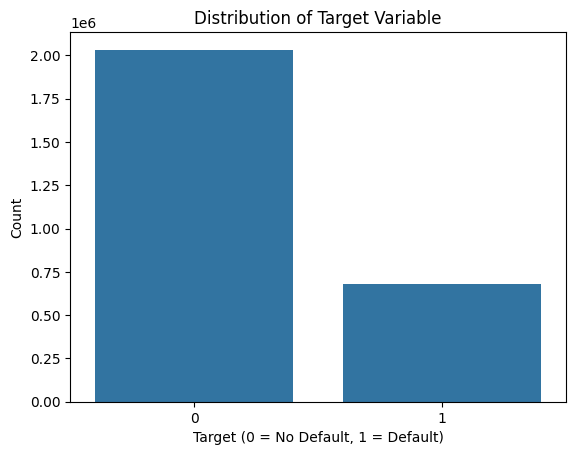

Target distribution by customer_ID:
target
0    74.020367
1    25.979633
Name: proportion, dtype: float64


In [13]:
# EDA

import seaborn as sns
import matplotlib.pyplot as plt

# Plot target distribution
sns.countplot(x='target', data=train)
plt.title("Distribution of Target Variable")
plt.xlabel("Target (0 = No Default, 1 = Default)")
plt.ylabel("Count")
plt.show()

# Print percentages
default_rate = train.groupby("customer_ID").first()["target"].value_counts(normalize=True) * 100
print("Target distribution by customer_ID:")
print(default_rate)


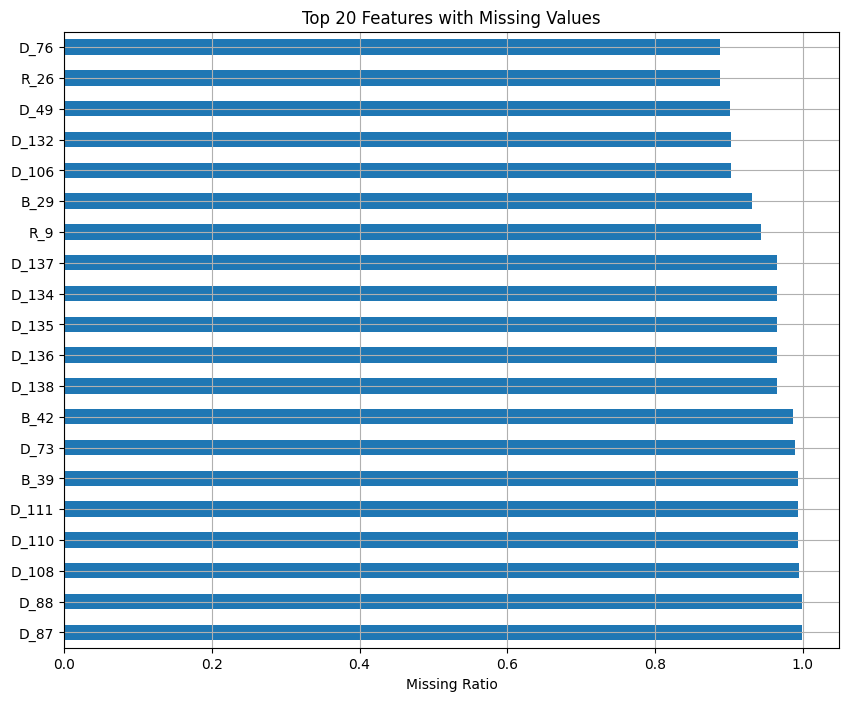

In [14]:
missing_ratio = train.isnull().mean().sort_values(ascending=False)
missing_ratio = missing_ratio[missing_ratio > 0]

# Display top 20 missing features
missing_ratio.head(20).plot(kind='barh', figsize=(10, 8))
plt.title("Top 20 Features with Missing Values")
plt.xlabel("Missing Ratio")
plt.grid(True)
plt.show()


In [16]:
# Prepocessing - Aggregation Pipeline

import pandas as pd
import numpy as np

df = train.copy()

# Convert S_2 to datetime
df['S_2'] = pd.to_datetime(df['S_2'])

# Exclude non-numeric columns
exclude_cols = ['customer_ID', 'S_2', 'target']
features = [col for col in df.columns if col not in exclude_cols and df[col].dtype != 'object']

# Aggregation functions
agg_funcs = ['mean', 'std', 'min', 'max', 'last']

# Group by customer_ID and aggregate
agg_df = df.groupby("customer_ID")[features].agg(agg_funcs)

# Flatten column names (multiindex)
agg_df.columns = ['_'.join(col).strip() for col in agg_df.columns.values]
agg_df.reset_index(inplace=True)

print("✅ Aggregated shape:", agg_df.shape)
agg_df.head()


✅ Aggregated shape: (224676, 931)


/tmp/ipython-input-16-3832942972.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  agg_df.reset_index(inplace=True)


,customer_ID,P_2_mean,P_2_std,P_2_min,P_2_max,P_2_last,D_39_mean,D_39_std,D_39_min,D_39_max,...,D_144_mean,D_144_std,D_144_min,D_144_max,D_144_last,D_145_mean,D_145_std,D_145_min,D_145_max,D_145_last
0,0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...,0.933824,0.024194,0.868580,0.960384,0.934745,0.010704,0.024444,0.001082,0.091505,...,0.005283,0.002598,0.000610,0.009616,0.002970,0.005814,0.003294,0.000995,0.009827,0.008533
1,00000fd6641609c6ece5454664794f0340ad84dddce9a2...,0.899820,0.022119,0.861109,0.929122,0.880519,0.215205,0.199150,0.002224,0.567403,...,0.004218,0.002871,0.000027,0.009568,0.003169,0.004902,0.002729,0.000796,0.009390,0.008514
2,00001b22f846c82c51f6e3958ccd81970162bae8b007e8...,0.878454,0.028911,0.797670,0.904482,0.880875,0.004181,0.002758,0.000802,0.009704,...,0.005113,0.003638,0.000129,0.009415,0.000834,0.004500,0.002152,0.000443,0.006932,0.003444
3,000041bdba6ecadd89a52d11886e8eaaec9325906c9723...,0.598969,0.020108,0.567442,0.623392,0.621776,0.048862,0.088466,0.000660,0.268476,...,0.004768,0.002654,0.000492,0.009919,0.005560,0.005236,0.003406,0.000029,0.009836,0.002983
4,00007889e4fcd2614b6cbe7f8f3d2e5c728eca32d9eb8a...,0.891679,0.042325,0.805045,0.940382,0.871900,0.004644,0.002882,0.000030,0.008680,...,0.004380,0.002633,0.000633,0.009436,0.006944,0.004219,0.003426,0.000083,0.009666,0.000905


In [19]:
# Load train_labels.csv
train_labels = pd.read_csv('/content/train_labels.csv')  # dosya yolunu ihtiyacına göre güncelle

# İlk birkaç satırı incele
print(train_labels.head())

# Veri şekli
print("train_labels shape:", train_labels.shape)


                                         customer_ID  target
0  0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...       0
1  00000fd6641609c6ece5454664794f0340ad84dddce9a2...       0
2  00001b22f846c82c51f6e3958ccd81970162bae8b007e8...       0
3  000041bdba6ecadd89a52d11886e8eaaec9325906c9723...       0
4  00007889e4fcd2614b6cbe7f8f3d2e5c728eca32d9eb8a...       0
train_labels shape: (458913, 2)


In [20]:
# Merge aggregated data with train labels
train_final = agg_df.merge(train_labels, on='customer_ID', how='left')

# Check shape and preview
print("✅ Final training shape:", train_final.shape)
print(train_final[['customer_ID', 'target']].head())


✅ Final training shape: (224676, 932)
                                         customer_ID  target
0  0000099d6bd597052cdcda90ffabf56573fe9d7c79be5f...       0
1  00000fd6641609c6ece5454664794f0340ad84dddce9a2...       0
2  00001b22f846c82c51f6e3958ccd81970162bae8b007e8...       0
3  000041bdba6ecadd89a52d11886e8eaaec9325906c9723...       0
4  00007889e4fcd2614b6cbe7f8f3d2e5c728eca32d9eb8a...       0


In [21]:
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
import lightgbm as lgb
from sklearn.metrics import roc_auc_score

# Drop customer_ID
X = train_final.drop(columns=['customer_ID', 'target'])
y = train_final['target']

# Fill missing values with median
imputer = SimpleImputer(strategy='median')
X_imputed = imputer.fit_transform(X)

# Train-validation split
X_train, X_val, y_train, y_val = train_test_split(X_imputed, y, test_size=0.2, random_state=42, stratify=y)


In [24]:
# Model Training and Evaluation with LightGBM

import lightgbm as lgb
from sklearn.metrics import roc_auc_score

# Dataset
train_data = lgb.Dataset(X_train, label=y_train)
val_data = lgb.Dataset(X_val, label=y_val)

# Parameters
params = {
    'objective': 'binary',
    'metric': 'auc',
    'boosting_type': 'gbdt',
    'verbosity': -1,
    'learning_rate': 0.05,
    'num_leaves': 64,
    'max_depth': -1,
    'feature_fraction': 0.8,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'seed': 42
}

# Train model with LightGBM callbacks
model = lgb.train(
    params,
    train_data,
    valid_sets=[val_data],
    callbacks=[
        lgb.early_stopping(stopping_rounds=50),
        lgb.log_evaluation(period=100)
    ],
    num_boost_round=1000
)

# Predict and evaluate
y_pred = model.predict(X_val, num_iteration=model.best_iteration)
auc_score = roc_auc_score(y_val, y_pred)

print(f"\n✅ Validation ROC-AUC: {auc_score:.5f}")


Training until validation scores don't improve for 50 rounds
[100]	valid_0's auc: 0.959601
[200]	valid_0's auc: 0.961101
[300]	valid_0's auc: 0.961226
Early stopping, best iteration is:
[265]	valid_0's auc: 0.961263

✅ Validation ROC-AUC: 0.96126


/tmp/ipython-input-25-299129979.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='importance', y='feature', data=importance_df, palette='viridis')


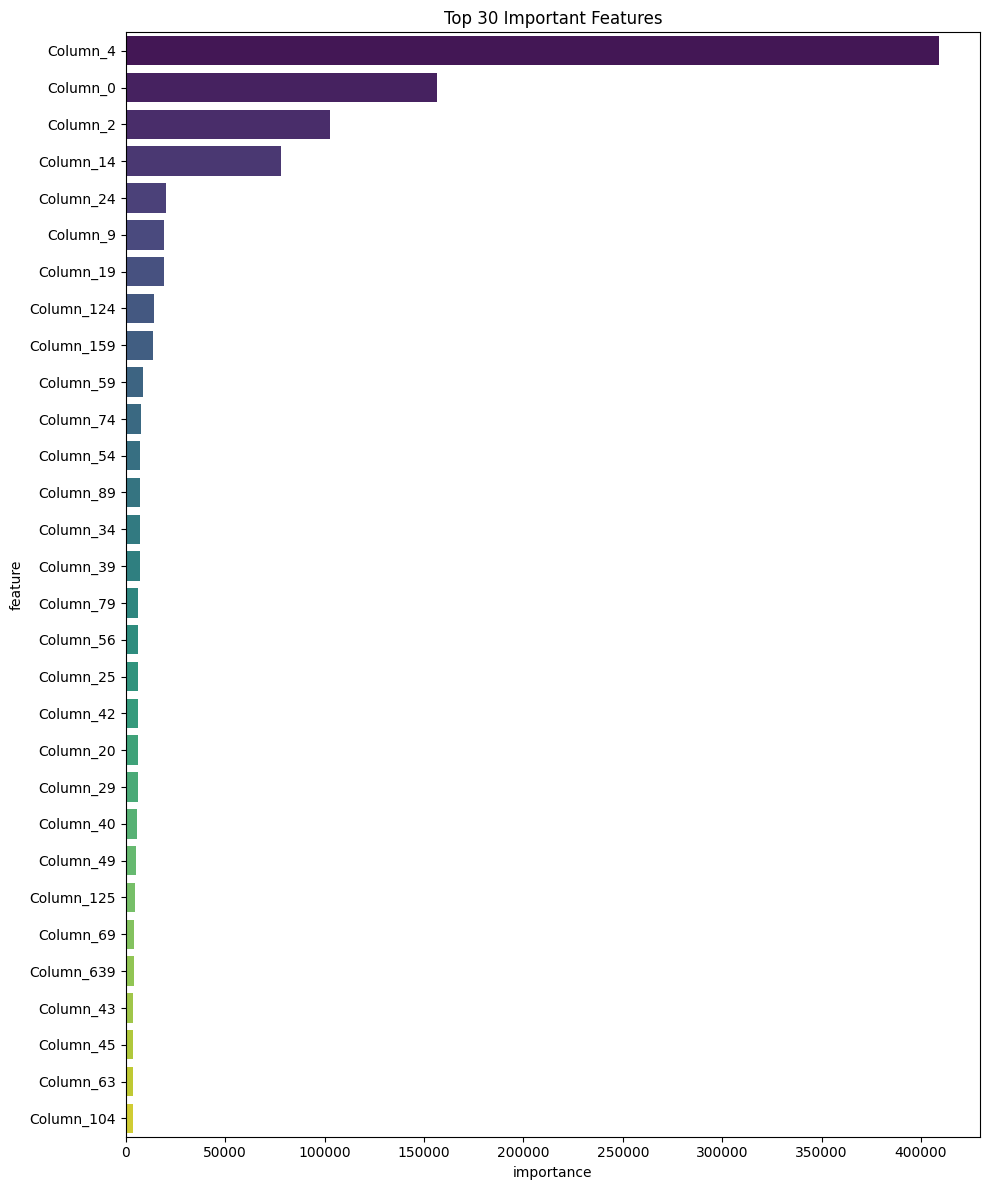

In [25]:
 # Feature Importance Visualization (LightGBM)

 import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Get feature importance from LightGBM model
importance_df = pd.DataFrame({
    'feature': model.feature_name(),
    'importance': model.feature_importance(importance_type='gain')  # 'split' da kullanılabilir
})

# Sort by importance
importance_df = importance_df.sort_values(by='importance', ascending=False).head(30)

# Plot
plt.figure(figsize=(10, 12))
sns.barplot(x='importance', y='feature', data=importance_df, palette='viridis')
plt.title('Top 30 Important Features')
plt.tight_layout()
plt.show()


/tmp/ipython-input-27-586160725.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="importance", y="feature", data=importance_df, palette="viridis")


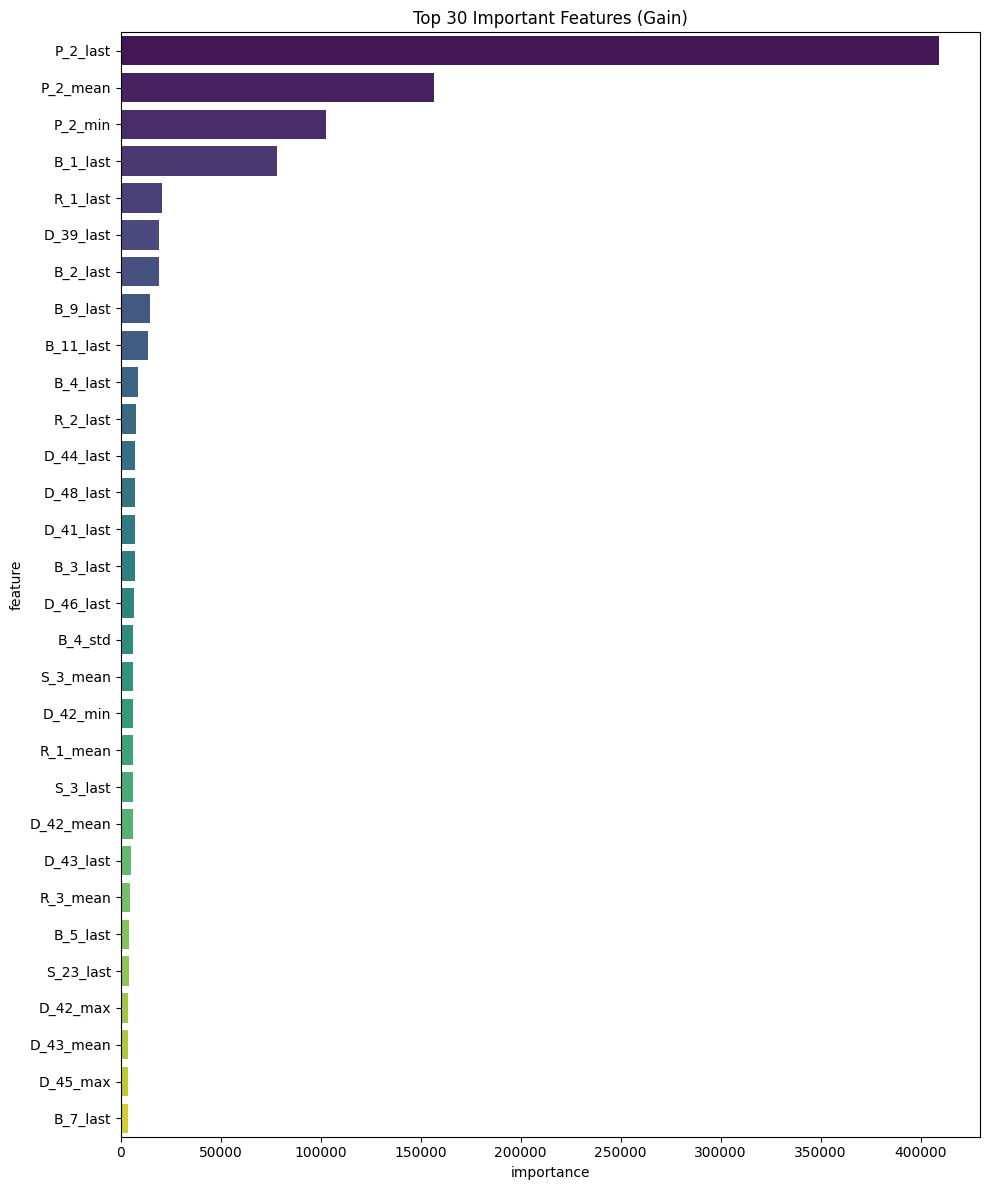

In [27]:
# Feature Importance Plot with Real Feature Names

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import lightgbm as lgb

# Use original column names from the aggregation DataFrame (excluding target)
feature_names = agg_df.drop(columns=["customer_ID"]).columns

# Create importance DataFrame
importance_df = pd.DataFrame({
    "feature": feature_names,
    "importance": model.feature_importance(importance_type="gain")
})

# Sort by importance
importance_df = importance_df.sort_values(by="importance", ascending=False).head(30)

# Plot
plt.figure(figsize=(10, 12))
sns.barplot(x="importance", y="feature", data=importance_df, palette="viridis")
plt.title("Top 30 Important Features (Gain)")
plt.tight_layout()
plt.show()


In [29]:
# !pip install shap

In [30]:
import shap
import lightgbm as lgb
import matplotlib.pyplot as plt


In [31]:
# SHAP Analysis

# Create SHAP values calculator
explainer = shap.TreeExplainer(model)

# Calculate SHAP values from training data
shap_values = explainer.shap_values(X_train)


/usr/local/lib/python3.11/dist-packages/shap/explainers/_tree.py:583: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


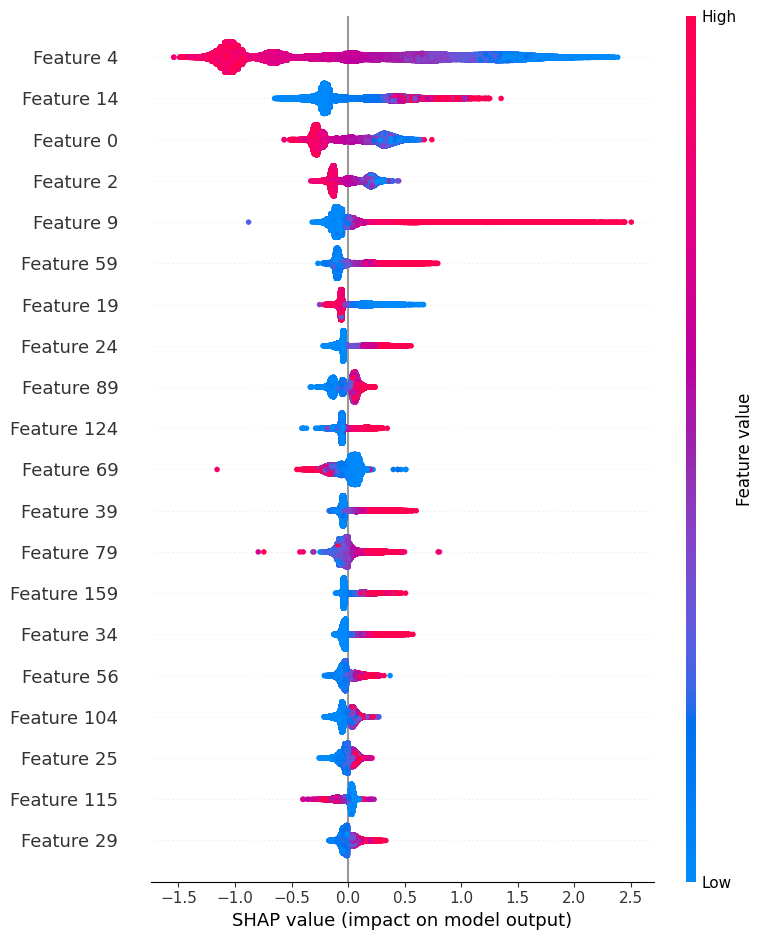

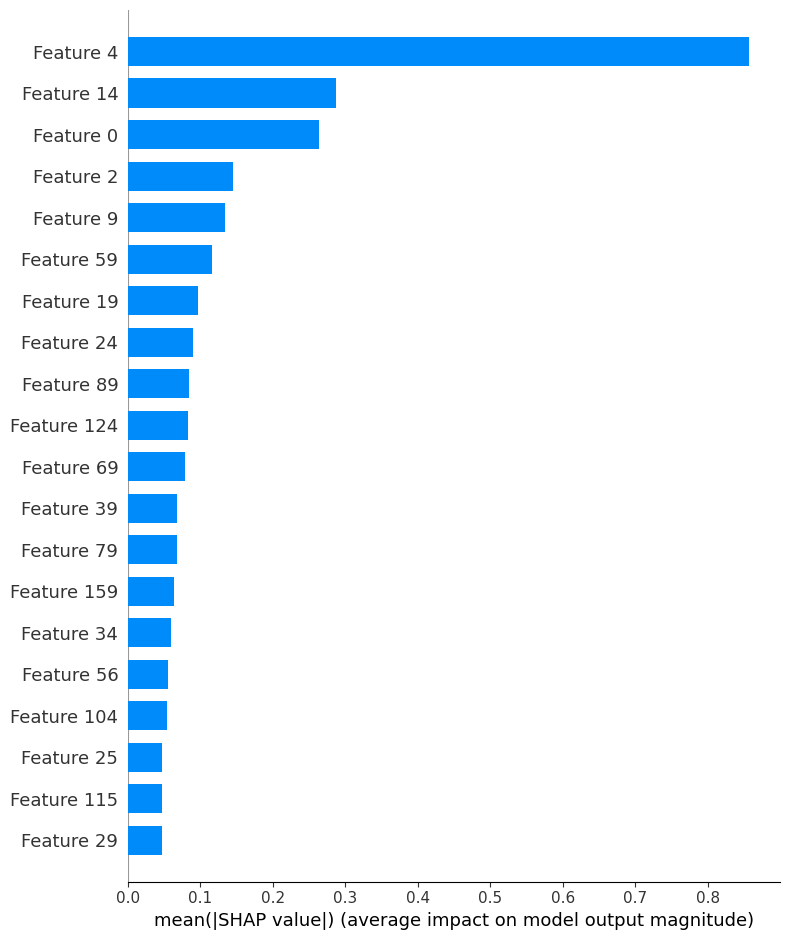

In [32]:
# Summary Plot

shap.summary_plot(shap_values, X_train, plot_type="dot")
shap.summary_plot(shap_values, X_train, plot_type="bar")

# Show SHAP contributions for a sample customer (first example)
shap.force_plot(explainer.expected_value, shap_values[0,:], X_train[0,:])

### SHAP Summary Plot (Beeswarm) – Direction of Impact

- **Feature 4 (P_2_last):** High values of this feature tend to have a negative impact on the model output. In other words, as P_2_last increases, the probability of default decreases.

- **Feature 14 (P_2_mean**) and **Feature 0 (P_2_min)** are also highly influential.

- **Color coding:**

  - **Red:** High feature values

  - **Blue:** Low feature values

This plot visualizes how each feature influences the model prediction directionally (positive or negative).

### SHAP Bar Plot – Average Impact Strength
Features such as P_2_last, P_2_mean, P_2_min, B_1_last, and D_39_last have the strongest average impact on the model.

Notably, "**last observed values**" (those with the _last suffix) appear to be the most predictive, highlighting the importance of a customer’s **recent behavior** in determining default risk.



In [33]:
import joblib

# Save the LightGBM model to a file
joblib.dump(model, "lgbm_default_model.pkl")

print("✅ Model saved as lgbm_default_model.pkl")


✅ Model saved as lgbm_default_model.pkl


| File Name | Description |
| ------------------------- | ---------------------------------------------- |
| `test_customer_low.csv` | Customer that will most likely not default |
| `test_customer_high.csv` | Customer that will most likely default |
| `test_customer_avg.csv` | Average risk customer |
| `test_customer_noise.csv` | Customer generated with random values |
| `test_customer_edge.csv` | Customer generated with extreme values (max/min) |